<a href="https://colab.research.google.com/github/SergeiVKalinin/ACerS_AE_2024/blob/main/5_MeasuredNoiseBO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Measured and Predictive Noise Bayesian optimization

*Prepared by Arpan Biswas (April 2024)*

*Adapted from Maxim Ziatdinov notebook*
https://colab.research.google.com/github/ziatdinovmax/gpax/blob/MeasuredNoiseGP/examples/MeasuredNoiseGP.ipynb

This notebook illustrates the usage of ```MeasuredNoiseGP``` model that extends the ```ExactGP``` model by allowing the inclusion of measured noise in the GP framework. Unlike standard GP models where noise is typically inferred, this model uses noise values obtained from repeated measurements at the same input points.

Install GPax:

In [13]:
!pip install -q git+https://github.com/ziatdinovmax/gpax

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


Imports:

In [14]:
import numpy as np
import matplotlib.pyplot as plt

import gpax

gpax.utils.enable_x64()

Generate synthetic data:

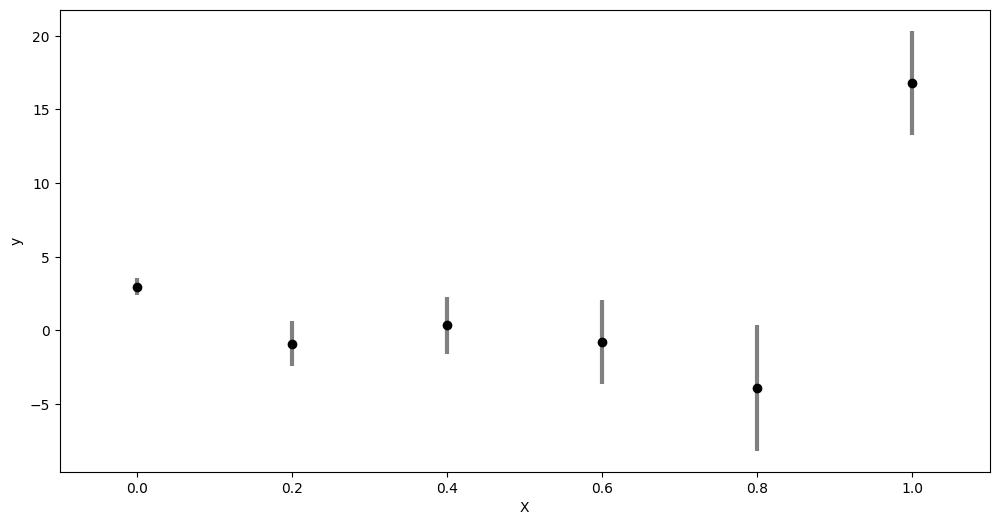

In [15]:
np.random.seed(1)

# Define the Forrester function
def forrester_function(x):
    return (6 * x - 2)**2 * np.sin(12 * x - 4)

# Function to generate variable noise based on X
def variable_noise(x):
    return 0.5 + 5 * x

# Generate X values
X = np.linspace(0, 1, 6)
#X = np.random.uniform(0, 1, 10)
num_measurements = 10  # Number of measurements per X

# Generate multiple noisy Y measurements for each X with variable noise
y_measurements = np.array([forrester_function(x) + np.random.normal(0, variable_noise(x), num_measurements) for x in X])

# Calculate mean and variance for Y measurements at each X
y = np.mean(y_measurements, axis=1)
measured_noise = np.var(y_measurements, axis=1)

# Plotting with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(
    X, y, yerr=np.sqrt(measured_noise), fmt='o', color='black', ecolor='grey',
    elinewidth=3, capsize=0)
plt.xlabel('X')
plt.ylabel('y')
plt.xlim(-0.1, 1.1)
plt.show()

# Gaussian Process with Measured Noise

Initialize and train ```MeasuredNoiseGP``` model.

In [16]:
# Get random number generator keys
key1, key2 = gpax.utils.get_keys()

# Initialize model
model = gpax.MeasuredNoiseGP(1, "Matern")

# Train
model.fit(key1, X, y, measured_noise)

sample: 100%|██████████| 4000/4000 [00:20<00:00, 199.19it/s, 3 steps of size 6.67e-01. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.92      1.72      0.34      0.02      2.21    737.29      1.00
    k_scale      5.72      6.26      3.67      0.34     12.44    895.19      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



Make a prediction on the denser grid (in real measurements, this will be a full discrete parameter space):

In [17]:
# Create a denser set of points
X_test = np.linspace(0, 1, 100)

# Make a prediction
y_pred, y_sampled = model.predict(key2, X_test, noise_prediction_method='linreg', n=100)

Plot the prediction:

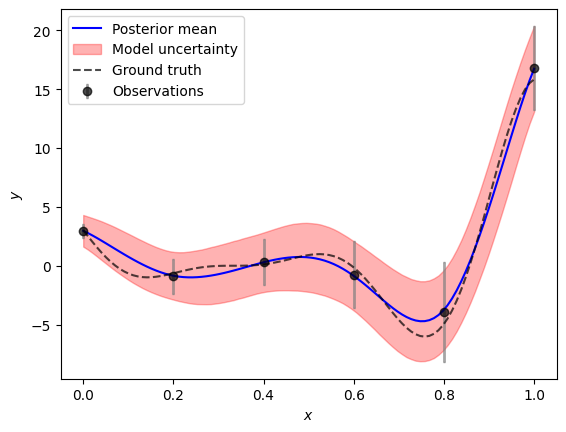

In [18]:
# Plot results
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.errorbar(
    X, y, yerr=np.sqrt(measured_noise), fmt='o', color='black', ecolor='grey',
    alpha=0.7, elinewidth=2, capsize=1, label='Observations', zorder=2)
ax.plot(X_test, y_pred, lw=1.5, zorder=2, c='b', label='Posterior mean')
ax.fill_between(X_test, y_pred - y_sampled.std(axis=(0,1)), y_pred + y_sampled.std(axis=(0,1)),
                color='r', alpha=0.3, label="Model uncertainty")
ax.plot(X_test, forrester_function(X_test), '--', label='Ground truth', c='k', alpha=0.7, zorder=2)
ax.legend(loc='best')

Plot the predicted noise for ```X_test```:

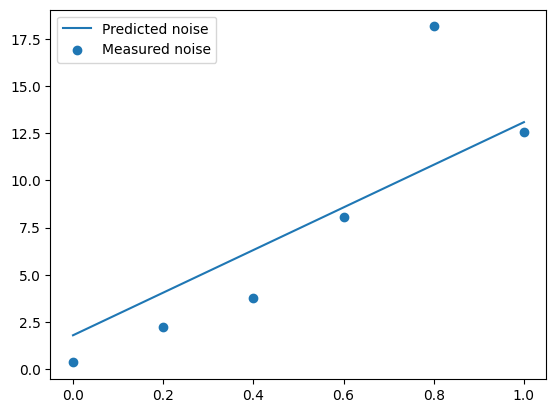

In [19]:
# Plot predicted (and measured) noise
plt.plot(X_test, model.noise_predicted, label="Predicted noise")
plt.scatter(X, measured_noise, label="Measured noise")
plt.legend()

#BO with Measured Noise - GP model


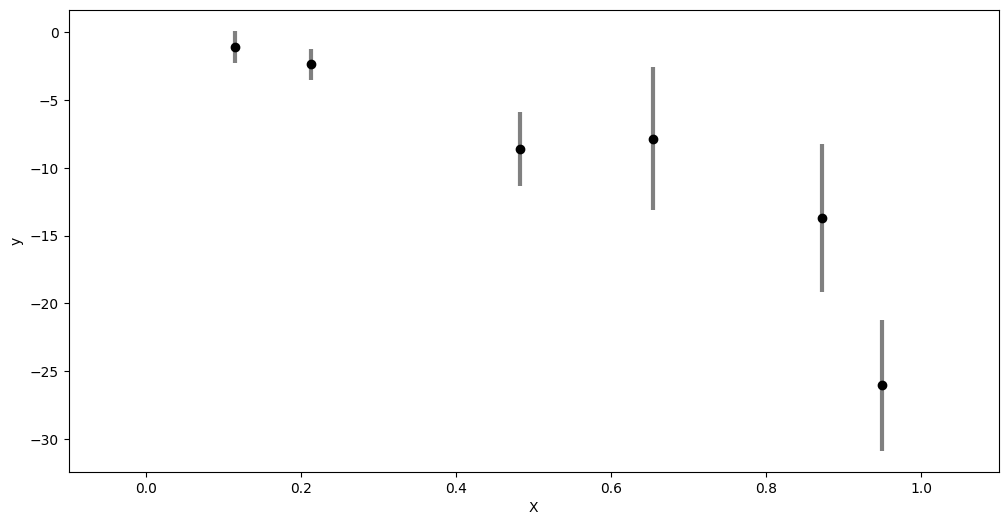

In [20]:
np.random.seed(1000)

# Define the Forrester function
def forrester_function(x):
    return -(6 * x - 2)**2 * np.sin(12 * x - 4) - 15*x

# Function to generate variable noise based on X
def variable_noise(x):
    return 0.5 + 6 * x

# Generate X values
train_x = np.random.uniform(0, 1, 6)
#X = np.random.uniform(0, 1, 10)
num_measurements = 10  # Number of measurements per X

# Generate multiple noisy Y measurements for each X with variable noise
np.random.seed(1)
train_y = np.array([forrester_function(x) + np.random.normal(0, variable_noise(x), num_measurements) for x in train_x])

# Calculate mean and variance for Y measurements at each X
train_ym = np.mean(train_y, axis=1)
train_noise = np.var(train_y, axis=1)

# Plotting with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(
    train_x, train_ym, yerr=np.sqrt(train_noise), fmt='o', color='black', ecolor='grey',
    elinewidth=3, capsize=0)
plt.xlabel('X')
plt.ylabel('y')
plt.xlim(-0.1, 1.1)
plt.show()


In [21]:
train_x, train_ym, train_noise

(array([0.65358959, 0.11500694, 0.95028286, 0.4821914 , 0.87247454,
        0.21233268]),
 array([ -7.85052313,  -1.07178501, -26.05016771,  -8.61806561,
        -13.70379412,  -2.34680912]),
 array([27.72657097,  1.41376388, 23.20899652,  7.55643513, 29.48717739,
         1.3061226 ]))

In [22]:
# Create a denser set of points
xs = np.linspace(0, 1, 100)

- Here, the noise model is considered as Gaussian Process

Step:1


sample: 100%|██████████| 1000/1000 [00:07<00:00, 138.86it/s, 3 steps of size 7.23e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.58      0.27      0.54      0.20      0.92    224.69      1.00
    k_scale     24.45     19.03     19.26      1.21     48.77    270.39      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



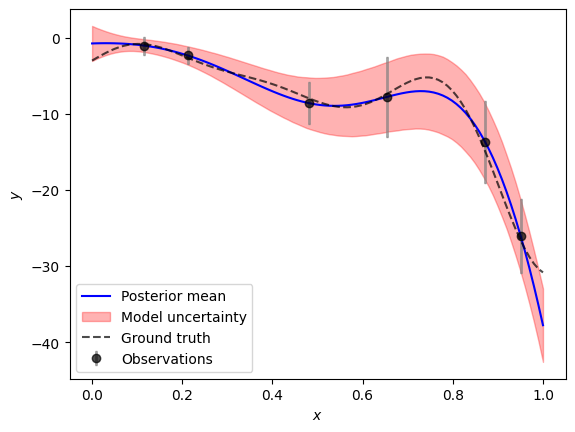

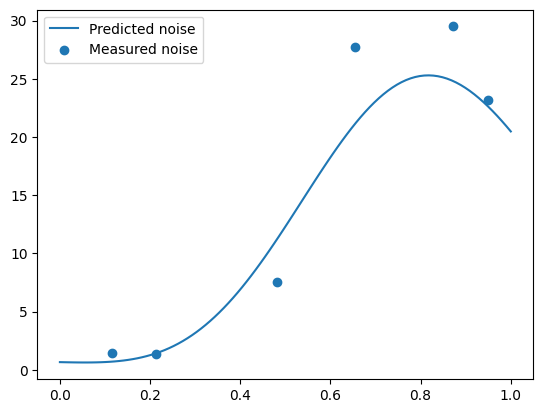

0


<ipython-input-23-e9c2df4f213c>:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx = int(idx)


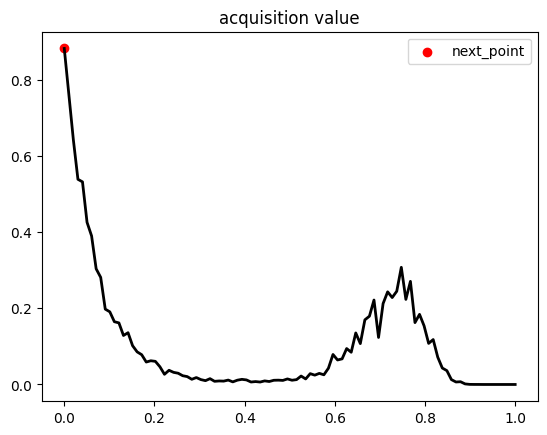

Step:2


sample: 100%|██████████| 1000/1000 [00:07<00:00, 134.95it/s, 3 steps of size 5.50e-01. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.72      1.20      0.48      0.11      1.23    180.07      1.00
    k_scale     21.27     18.06     16.59      1.54     41.88    339.37      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



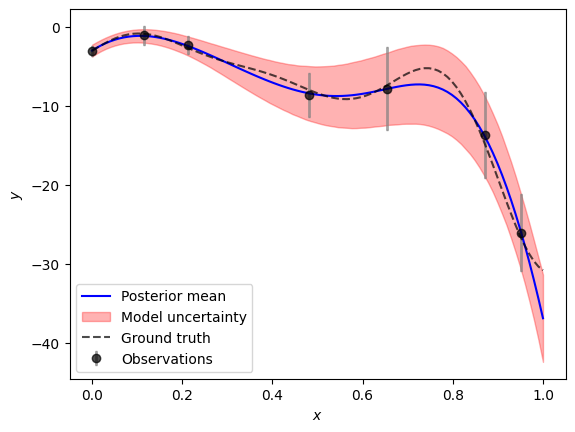

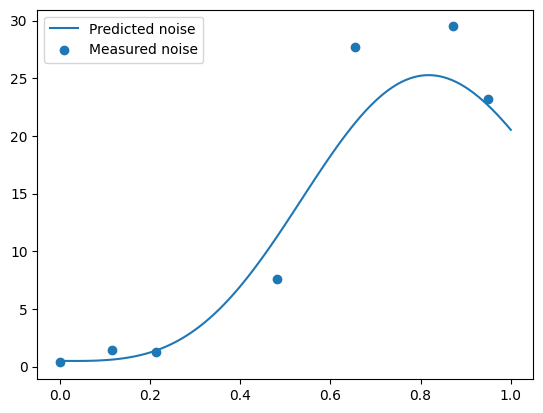

[ 0 76]


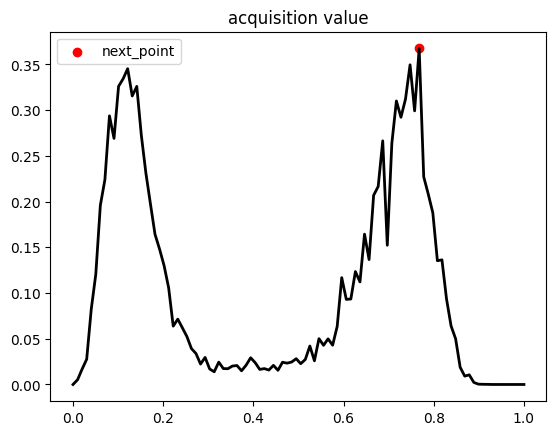

Step:3


sample: 100%|██████████| 1000/1000 [00:06<00:00, 158.09it/s, 3 steps of size 6.96e-01. acc. prob=0.88]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.72      0.76      0.52      0.10      1.32    157.01      1.03
    k_scale     18.77     16.09     14.04      0.44     37.36    290.41      1.01
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



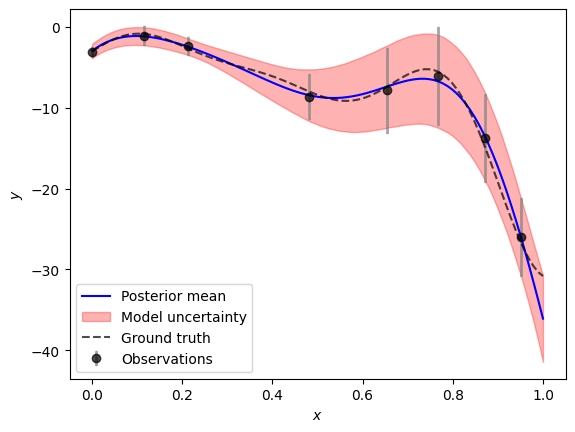

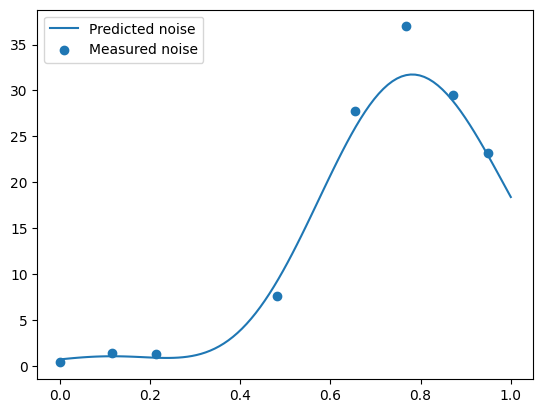

[ 0 76 74]


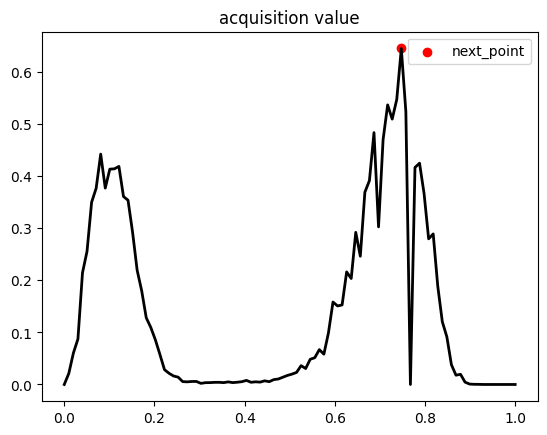

Step:4


sample: 100%|██████████| 1000/1000 [00:06<00:00, 147.21it/s, 3 steps of size 6.47e-01. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.84      1.10      0.58      0.14      1.46    146.13      1.01
    k_scale     16.75     15.98     12.20      1.33     31.81    212.20      1.01
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



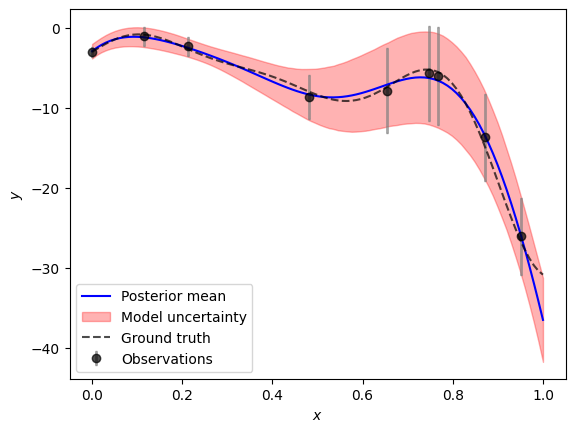

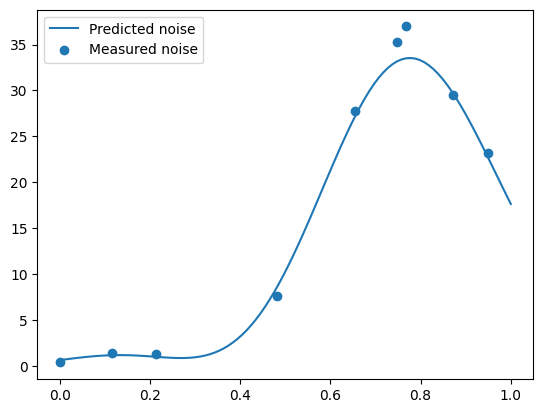

[ 0 76 74 73]


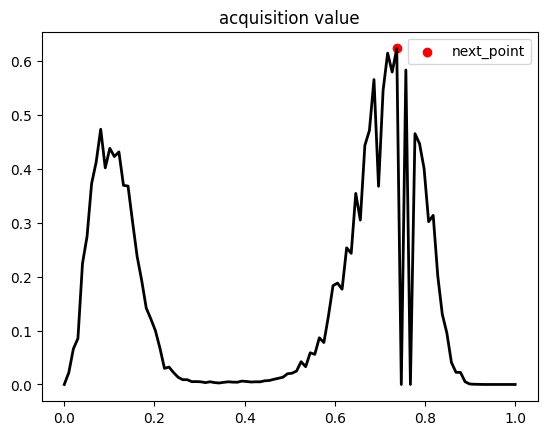

Step:5


sample: 100%|██████████| 1000/1000 [00:06<00:00, 149.74it/s, 3 steps of size 7.70e-01. acc. prob=0.84]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.79      1.06      0.57      0.13      1.33    169.83      1.00
    k_scale     15.86     14.24     12.29      0.85     31.45    359.27      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



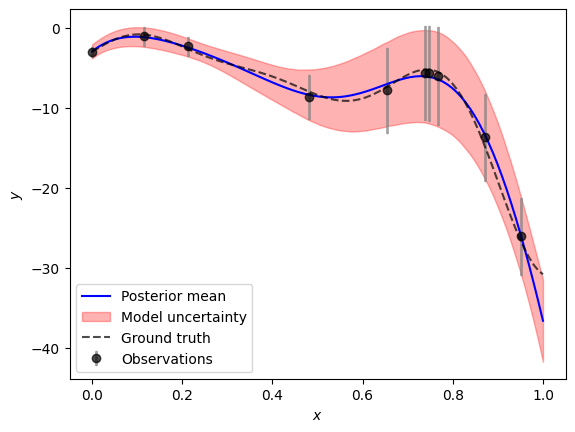

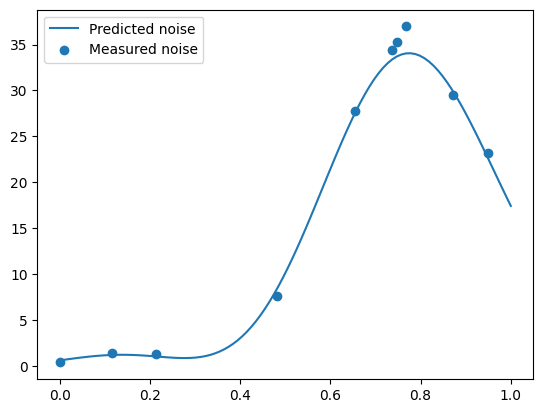

[ 0 76 74 73 71]


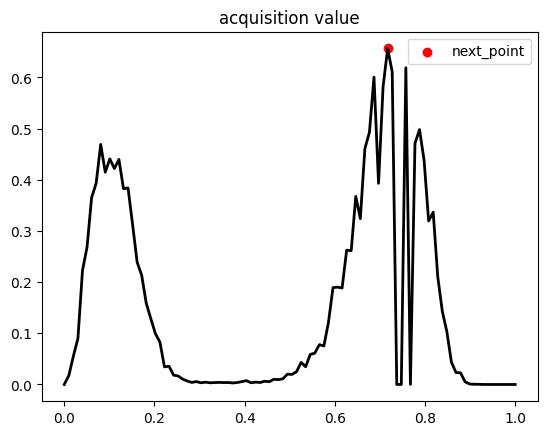

Step:6


sample: 100%|██████████| 1000/1000 [00:06<00:00, 148.14it/s, 1 steps of size 8.10e-01. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.89      1.25      0.58      0.09      1.58    152.23      1.01
    k_scale     15.56     14.85     11.89      0.94     30.07    232.10      1.01
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



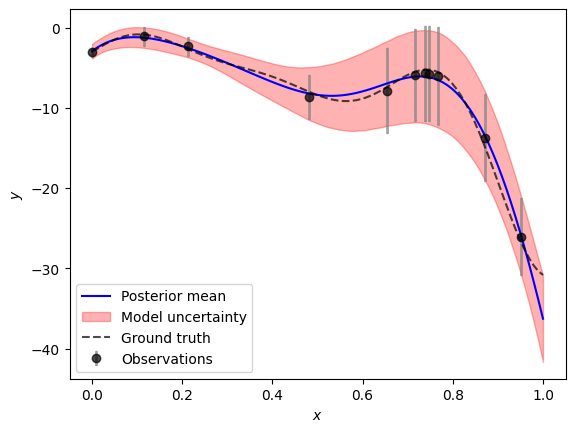

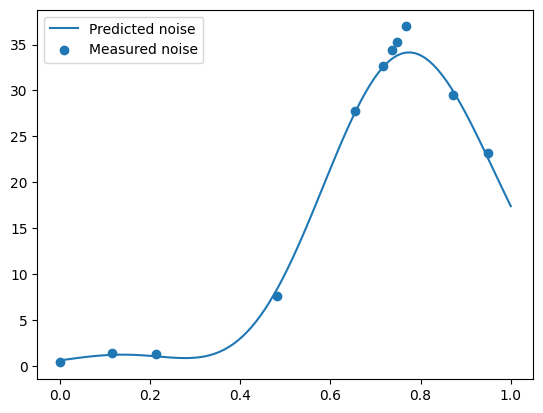

[ 0 76 74 73 71 72]


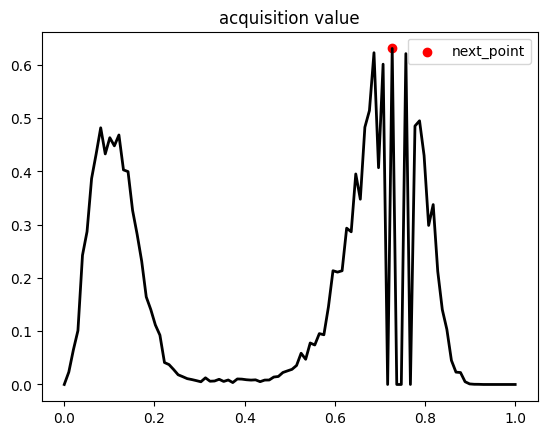

Step:7


sample: 100%|██████████| 1000/1000 [00:07<00:00, 132.43it/s, 3 steps of size 6.65e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.84      0.75      0.63      0.14      1.55    148.02      1.01
    k_scale     14.54     13.32     11.14      0.69     29.43    214.58      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



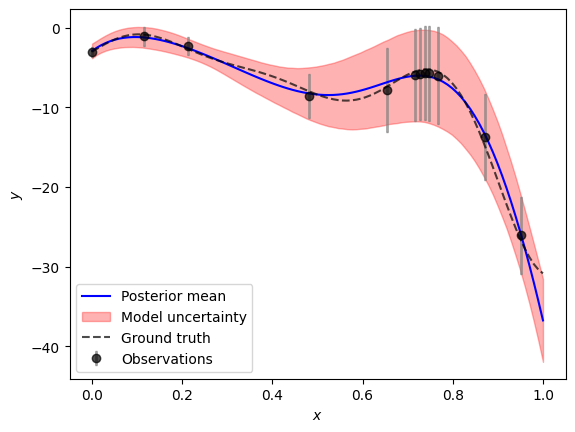

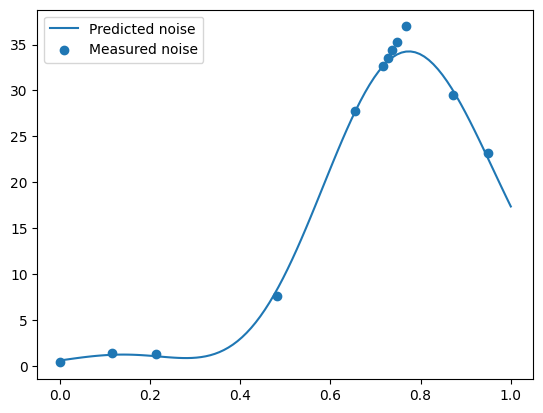

[ 0 76 74 73 71 72 68]


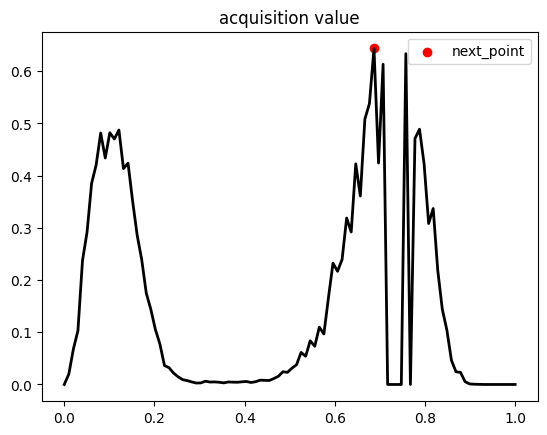

Step:8


sample: 100%|██████████| 1000/1000 [00:07<00:00, 125.03it/s, 3 steps of size 7.13e-01. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.83      1.09      0.61      0.14      1.41    139.23      1.01
    k_scale     14.59     13.85     11.16      0.95     28.35    275.22      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



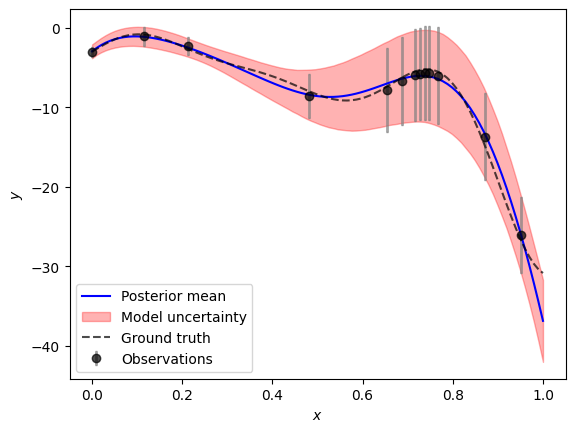

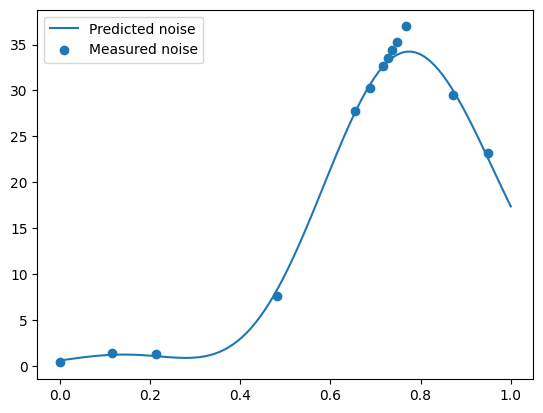

[ 0 76 74 73 71 72 68 75]


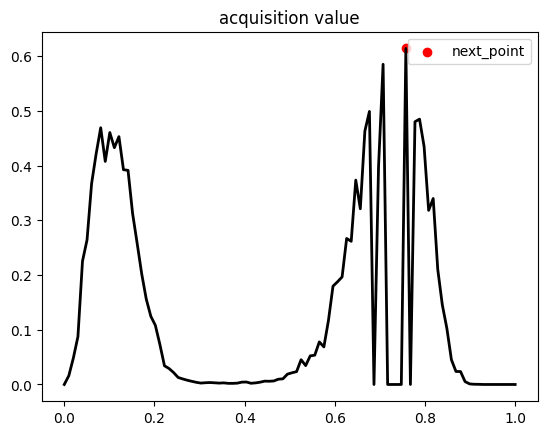

Step:9


sample: 100%|██████████| 1000/1000 [00:08<00:00, 121.45it/s, 3 steps of size 7.02e-01. acc. prob=0.88]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.91      1.10      0.66      0.14      1.63    155.01      1.00
    k_scale     12.22     10.20      9.44      0.97     23.64    325.53      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



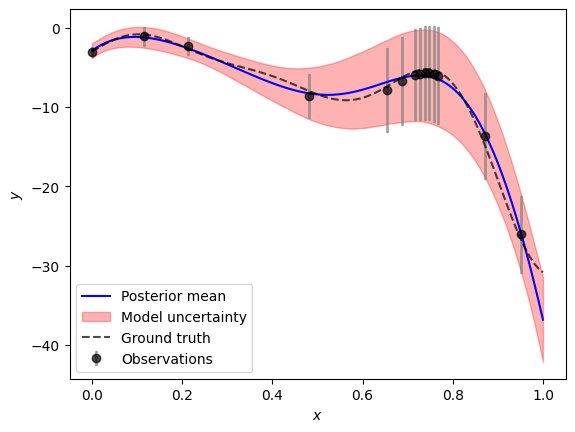

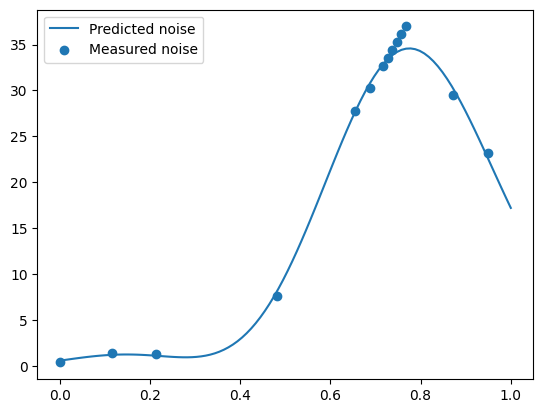

[ 0 76 74 73 71 72 68 75 70]


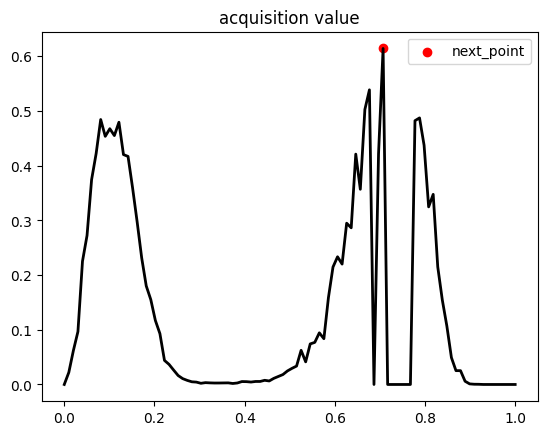

Step:10


sample: 100%|██████████| 1000/1000 [00:08<00:00, 113.44it/s, 3 steps of size 7.48e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.96      1.16      0.71      0.13      1.73    147.86      1.02
    k_scale     13.02     12.29      9.85      1.16     25.61    245.83      1.03
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



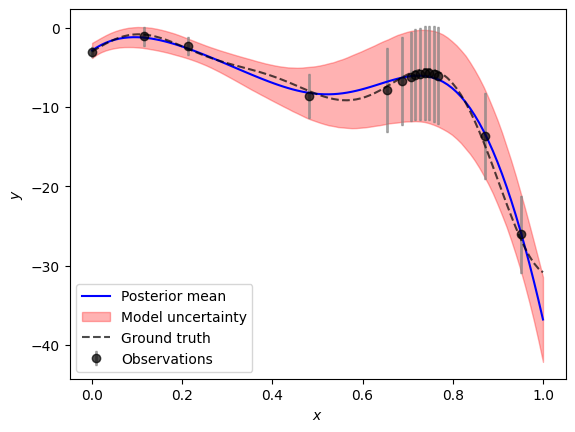

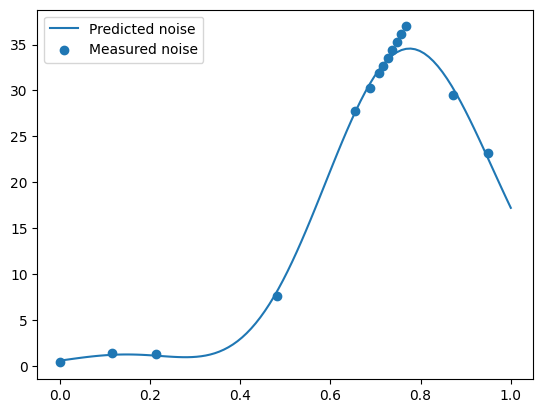

[ 0 76 74 73 71 72 68 75 70 67]


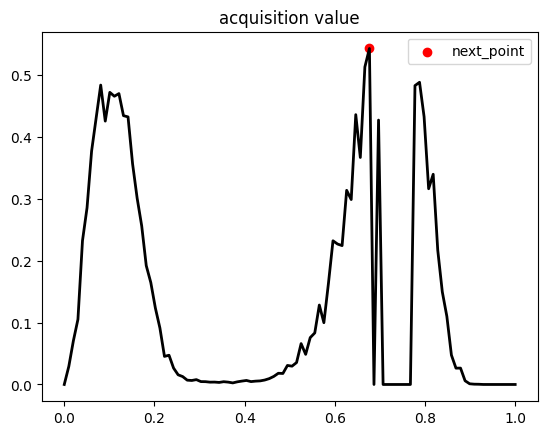

Step:11


sample: 100%|██████████| 1000/1000 [00:06<00:00, 149.68it/s, 3 steps of size 6.39e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.82      0.65      0.61      0.12      1.52    202.69      1.02
    k_scale     14.20     12.56     10.63      1.06     27.18    141.74      1.03
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



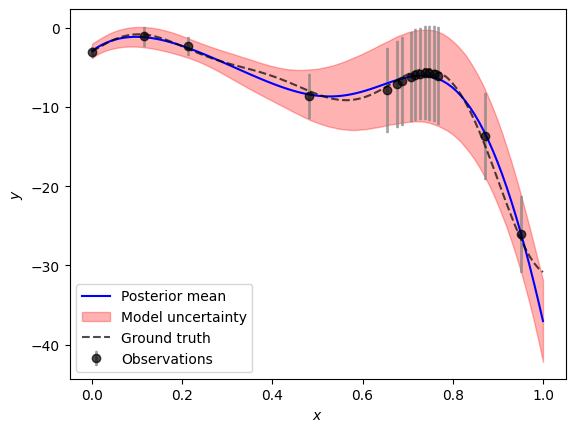

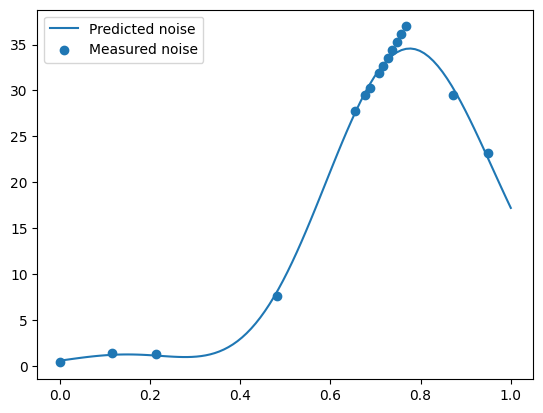

[ 0 76 74 73 71 72 68 75 70 67 78]


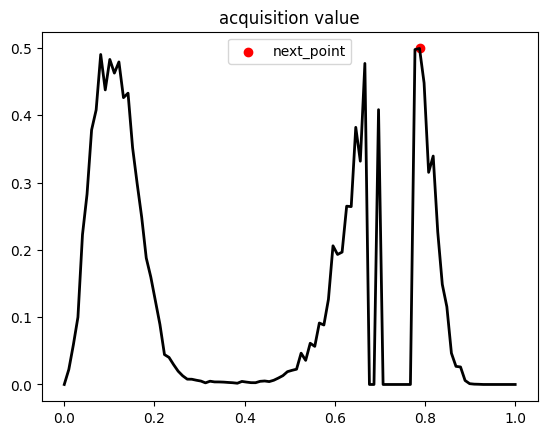

Step:12


sample: 100%|██████████| 1000/1000 [00:09<00:00, 104.65it/s, 3 steps of size 6.73e-01. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.87      1.12      0.63      0.09      1.43    263.83      1.00
    k_scale     13.13     12.71      9.81      1.47     23.91    247.38      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



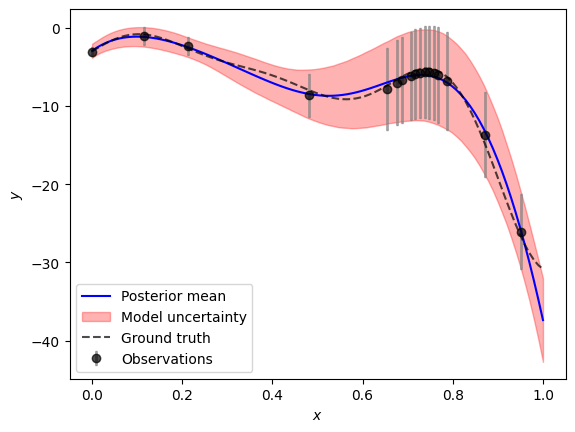

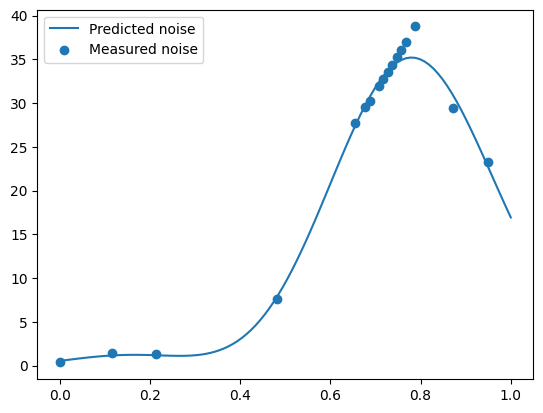

[ 0 76 74 73 71 72 68 75 70 67 78 77]


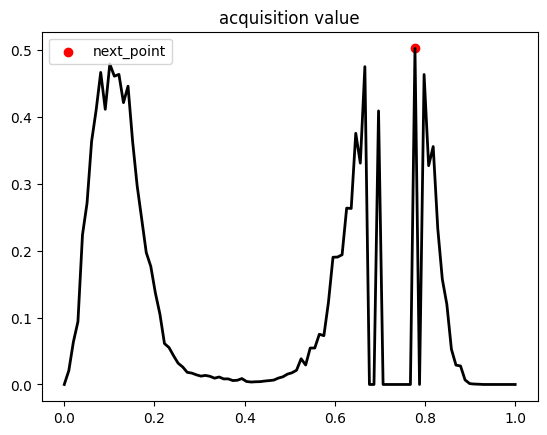

Step:13


sample: 100%|██████████| 1000/1000 [00:09<00:00, 105.97it/s, 3 steps of size 8.73e-01. acc. prob=0.88]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.82      0.93      0.65      0.12      1.38    168.34      1.01
    k_scale     14.04     12.96     10.52      1.57     26.70    239.84      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



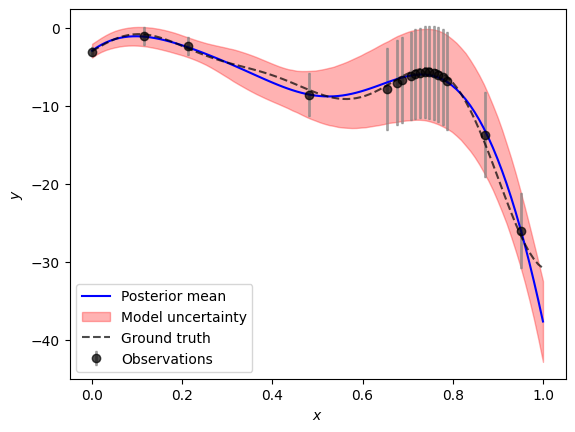

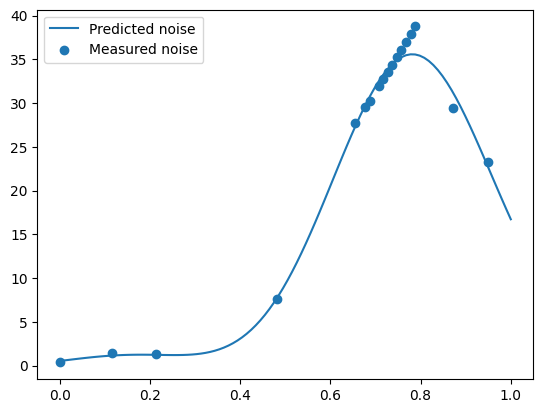

[ 0 76 74 73 71 72 68 75 70 67 78 77 66]


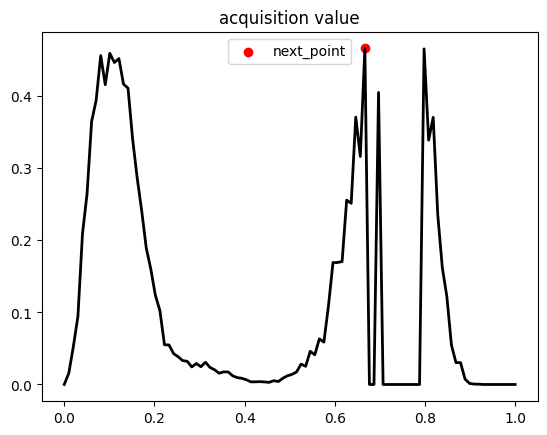

Step:14


sample: 100%|██████████| 1000/1000 [00:10<00:00, 100.00it/s, 3 steps of size 7.83e-01. acc. prob=0.88]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.78      0.75      0.63      0.13      1.44    292.71      1.00
    k_scale     14.61     15.54     10.52      1.24     27.89    216.99      1.01
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



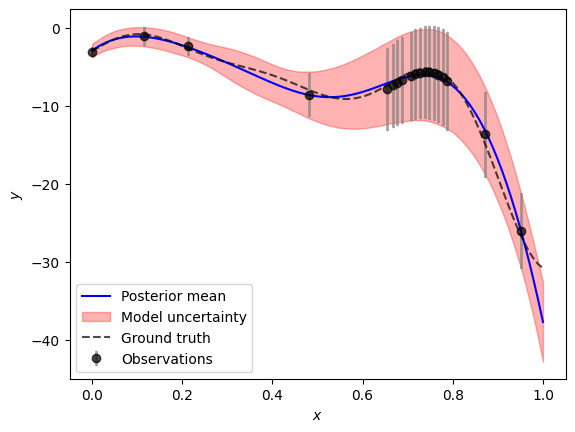

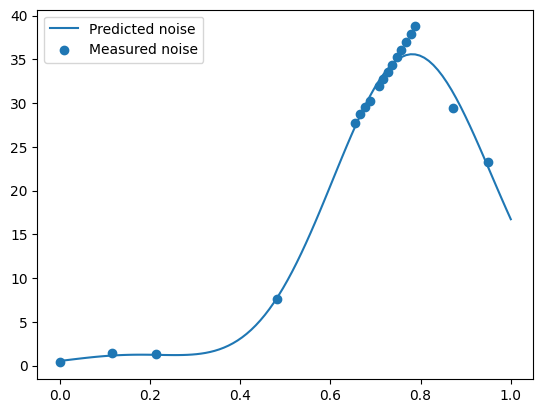

[ 0 76 74 73 71 72 68 75 70 67 78 77 66 79]


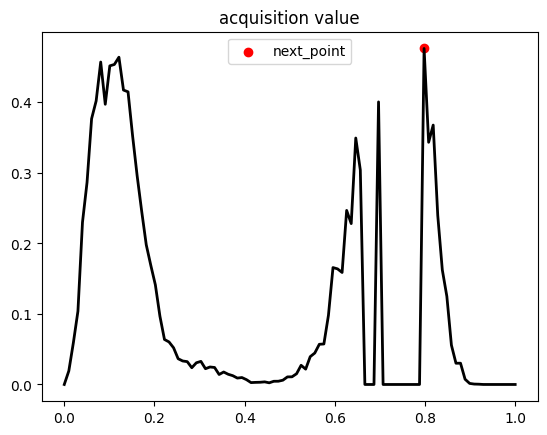

Step:15


sample: 100%|██████████| 1000/1000 [00:10<00:00, 99.41it/s, 3 steps of size 7.38e-01. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.88      0.81      0.68      0.12      1.57    219.90      1.01
    k_scale     12.39      9.77      9.98      1.09     23.25    198.97      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



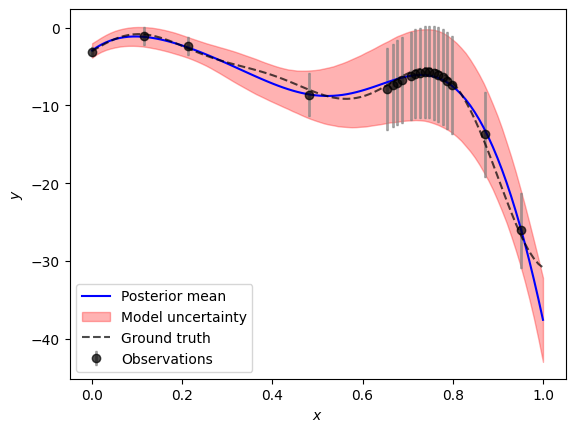

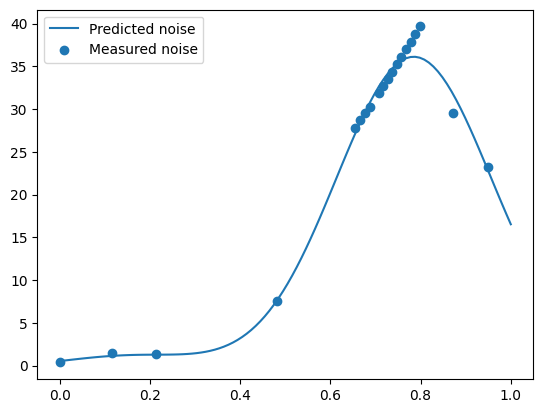

[ 0 76 74 73 71 72 68 75 70 67 78 77 66 79 12]


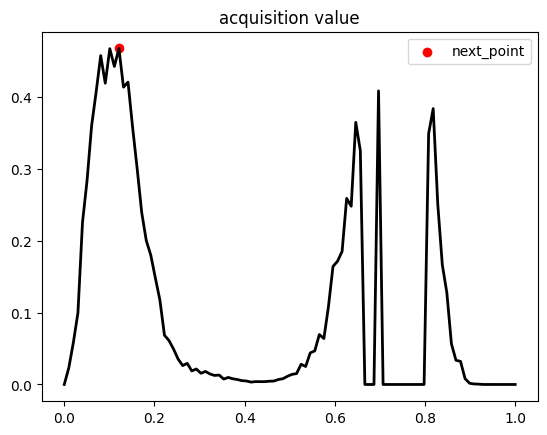

In [23]:
N = 15
X_test =xs
#X_test = np.reshape(X_test,(X_test.shape[0],1))
X_test_full = xs
#X_test_full = np.reshape(X_test_full,(X_test_full.shape[0],1))
# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()
idx = []
for i in range(1, N+1):
    print("Step:"+str(i))

    # Calculate mean values of the measured samples
    train_ym = np.mean(train_y, axis=1)
    # Calculate noise of the measured samples
    train_noise = np.var(train_y, axis=1)

    #train_noise = train_noise*10 #Scalling to validate (Dont need for real implementation)
    # Initialize MF model
    gp_model = gpax.MeasuredNoiseGP(1, kernel='RBF')
    # Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
    gp_model.fit(rng_key, train_x, train_ym, train_noise, num_warmup=500, num_samples=500, num_chains=1)


    if ((i == 1) or ((i % 1) == 0)): # Check predictions after every 5 BO runs
        y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test, noise_prediction_method='gpreg', n=100)


        # Plot results
        _, ax = plt.subplots(dpi=100)
        ax.set_xlabel("$x$")
        ax.set_ylabel("$y$")
        ax.errorbar(
            train_x, train_ym, yerr=np.sqrt(train_noise), fmt='o', color='black', ecolor='grey',
            alpha=0.7, elinewidth=2, capsize=1, label='Observations', zorder=2)
        ax.plot(X_test, y_pred, lw=1.5, zorder=2, c='b', label='Posterior mean')
        ax.fill_between(X_test, y_pred - y_sampled.std(axis=(0,1)), y_pred + y_sampled.std(axis=(0,1)),
                        color='r', alpha=0.3, label="Model uncertainty")
        ax.plot(X_test, forrester_function(X_test), '--', label='Ground truth', c='k', alpha=0.7, zorder=2)
        ax.legend(loc='best')
        plt.show()
        # Plot predicted (and measured) noise
        plt.plot(X_test, gp_model.noise_predicted, label="Predicted noise")
        plt.scatter(train_x, train_noise, label="Measured noise")
        plt.legend()
        plt.show()

    # Compute the MF acq function - EI based

    acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, maximize=True, noiseless=True)

    # Avoiding measurement at same locations
    acq=np.array(acq)
    acq[idx] = 0
    next_point_idx = acq.argmax()
    next_point_val = acq.max()
    idx = np.hstack((idx, next_point_idx))
    if i == 1:
        idx = int(idx)
        print(idx)
    else:
        idx = idx
        print(idx)

    #Plotting acq function
    plt.plot(X_test, acq, "k-", linewidth=2)
    plt.scatter(X_test[next_point_idx], next_point_val, c="r", label="next_point")
    plt.legend(loc="best")
    plt.title("acquisition value")
    plt.show()

    if next_point_val == 0:
        print("Model sufficiently learned")
        break
    else:
        next_point = X_test[next_point_idx]
        train_x = np.hstack((train_x, next_point))
        #print(next_point_idx, next_point, next_point_norm, train_x_full, train_x_full_norm)
        np.random.seed(1)
        t_y= np.array(forrester_function(train_x[-1]) + np.random.normal(0, variable_noise(train_x[-1]), num_measurements))
        train_y = np.vstack((train_y, t_y))



#BO with Measured Noise - Linear Model


- Here, the noise model is considered as Linear

Step:1


sample: 100%|██████████| 1000/1000 [00:13<00:00, 76.14it/s, 3 steps of size 8.00e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.82      1.15      0.59      0.18      1.34    171.24      1.01
    k_scale     14.93     14.57     11.49      1.63     27.38    234.77      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



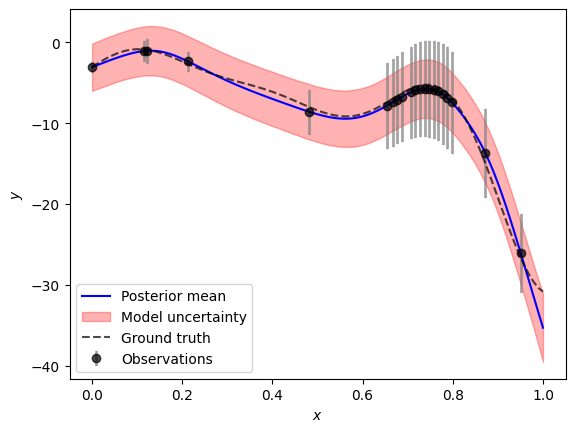

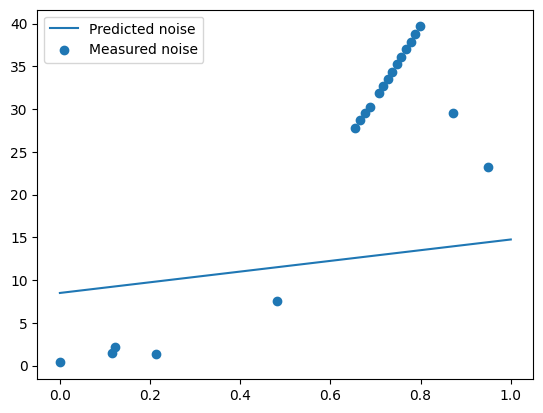

14


<ipython-input-24-096b08eed074>:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx = int(idx)


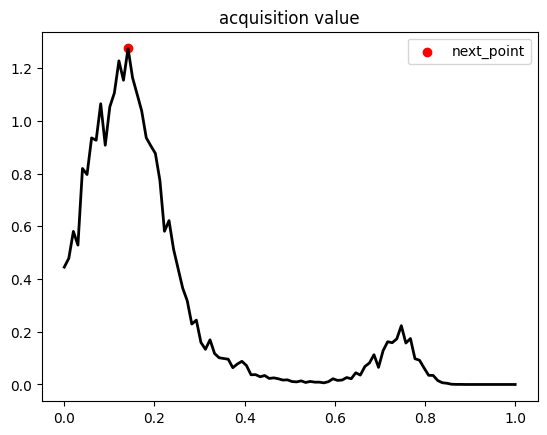

Step:2


sample: 100%|██████████| 1000/1000 [00:13<00:00, 72.28it/s, 3 steps of size 7.58e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.70      0.63      0.56      0.13      1.20    280.18      1.00
    k_scale     16.24     13.58     13.05      1.86     31.65    245.05      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



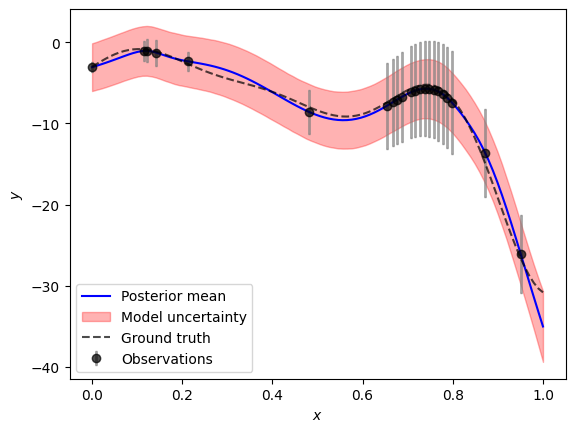

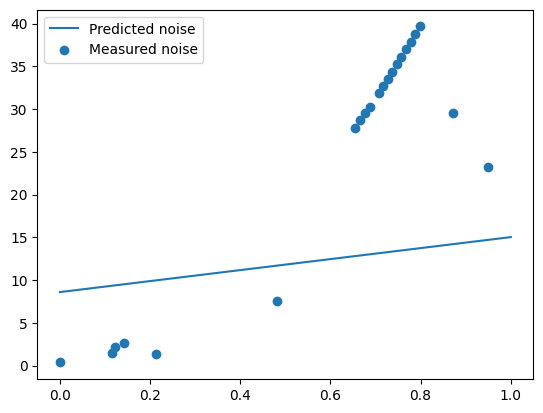

[14 12]


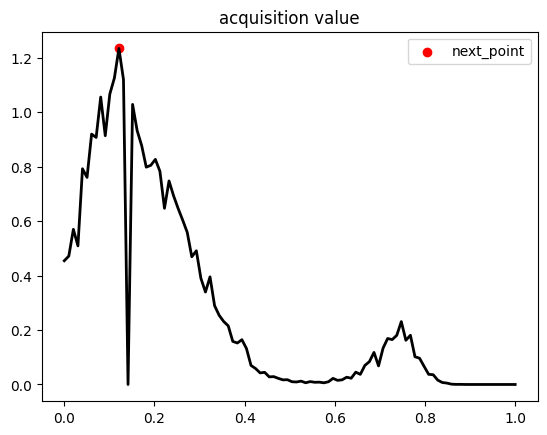

Step:3


sample: 100%|██████████| 1000/1000 [00:14<00:00, 69.87it/s, 3 steps of size 8.54e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.63      0.67      0.51      0.12      1.04    244.75      1.00
    k_scale     17.15     15.11     13.33      0.95     33.15    225.38      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



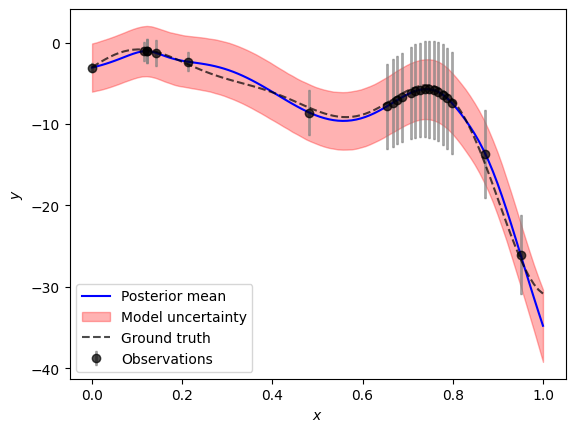

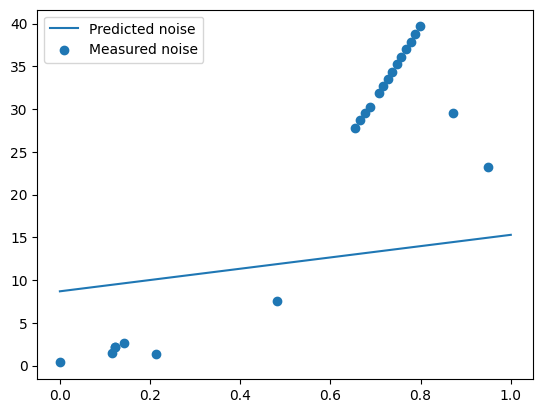

[14 12 13]


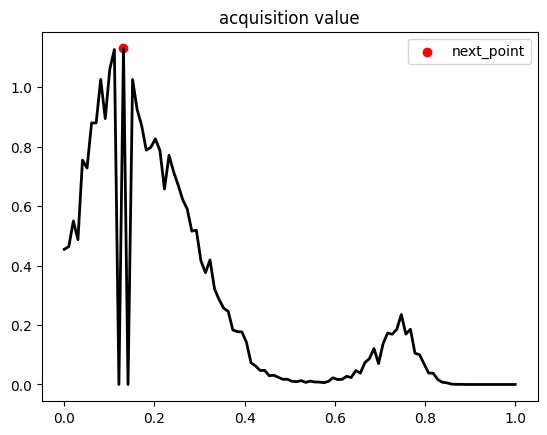

Step:4


sample: 100%|██████████| 1000/1000 [00:15<00:00, 65.31it/s, 3 steps of size 7.80e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.56      0.42      0.46      0.16      0.96    192.67      1.00
    k_scale     17.66     13.65     14.24      2.02     33.43    226.21      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



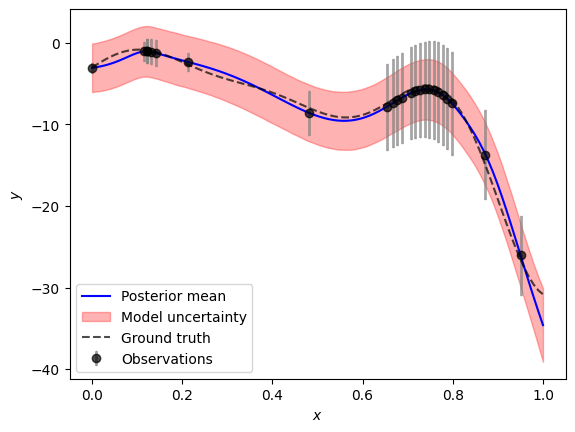

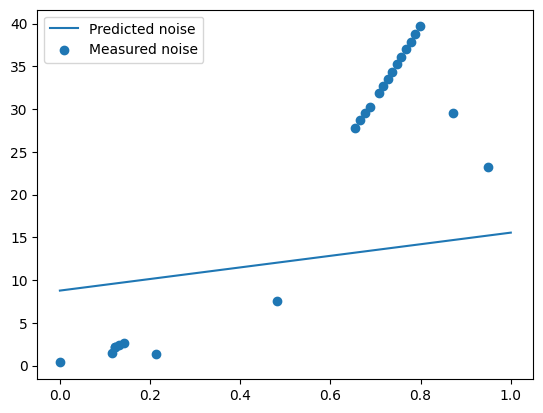

[14 12 13 11]


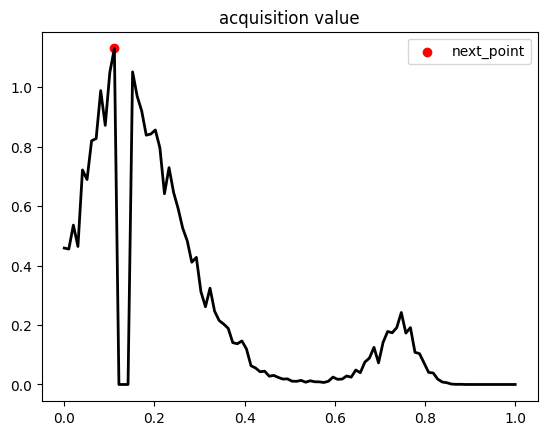

Step:5


sample: 100%|██████████| 1000/1000 [00:15<00:00, 63.82it/s, 3 steps of size 8.34e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.52      0.37      0.43      0.15      0.94    195.42      1.00
    k_scale     17.52     12.36     14.55      2.09     32.37    232.47      1.01
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



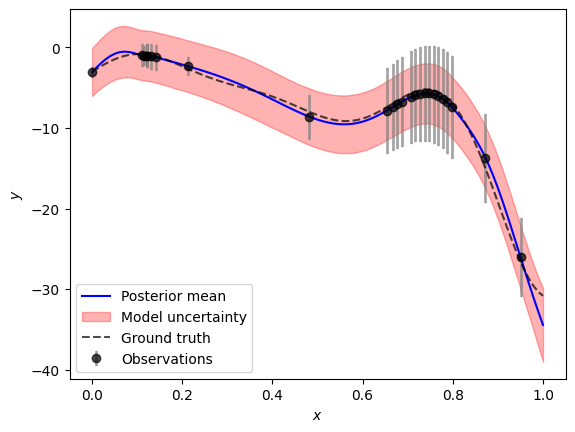

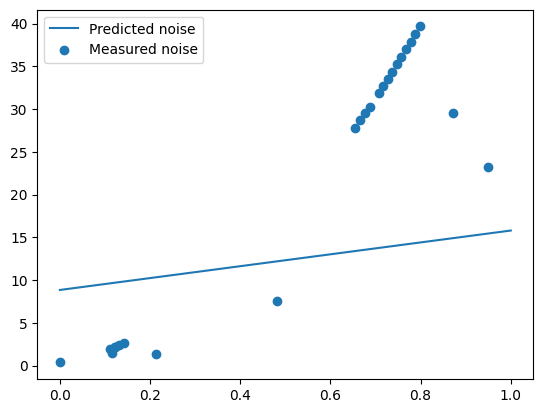

[14 12 13 11  6]


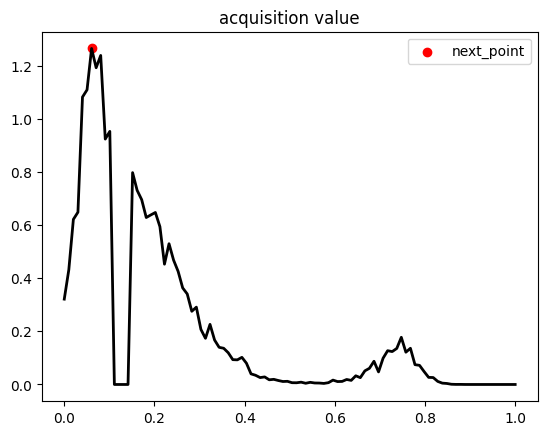

Step:6


sample: 100%|██████████| 1000/1000 [00:16<00:00, 62.28it/s, 3 steps of size 8.30e-01. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.51      0.31      0.46      0.11      0.83    276.28      1.00
    k_scale     18.17     14.59     14.22      1.45     35.99    357.24      1.01
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



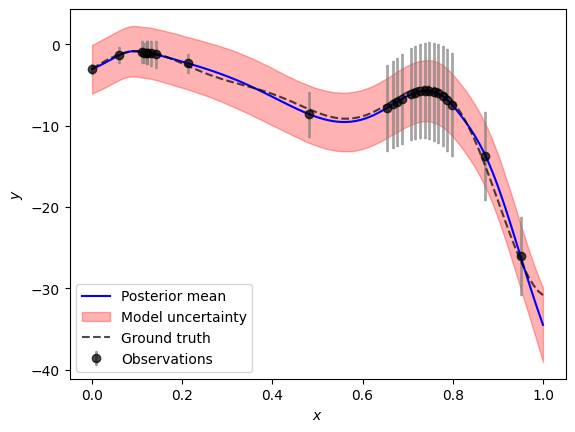

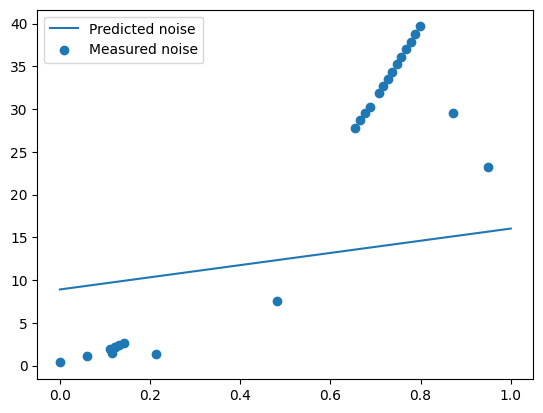

[14 12 13 11  6  8]


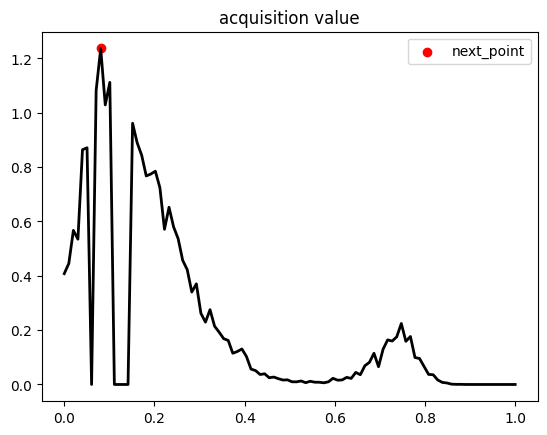

Step:7


sample: 100%|██████████| 1000/1000 [00:16<00:00, 59.08it/s, 3 steps of size 7.32e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.49      0.30      0.42      0.12      0.89    190.42      1.01
    k_scale     19.26     16.37     14.79      2.27     37.67    216.30      1.01
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



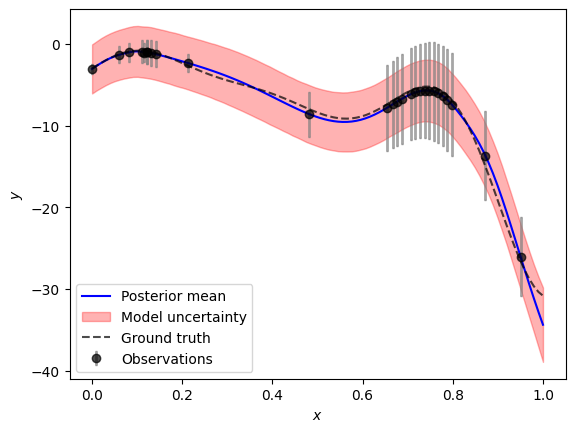

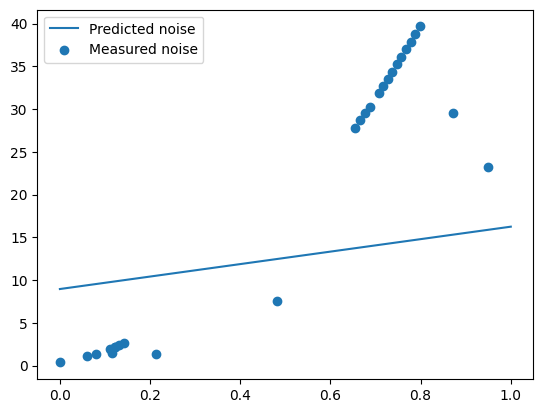

[14 12 13 11  6  8 10]


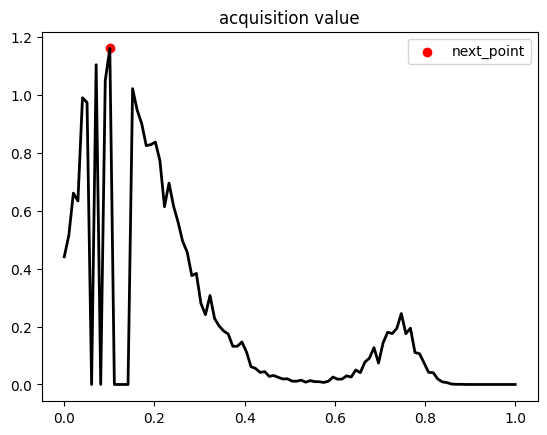

Step:8


sample: 100%|██████████| 1000/1000 [00:19<00:00, 51.76it/s, 3 steps of size 7.75e-01. acc. prob=0.94]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.49      0.30      0.41      0.13      0.84    218.35      1.00
    k_scale     18.36     15.18     14.89      2.45     34.52    373.74      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



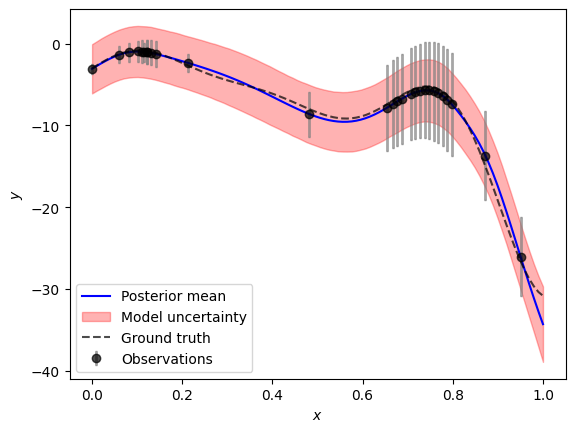

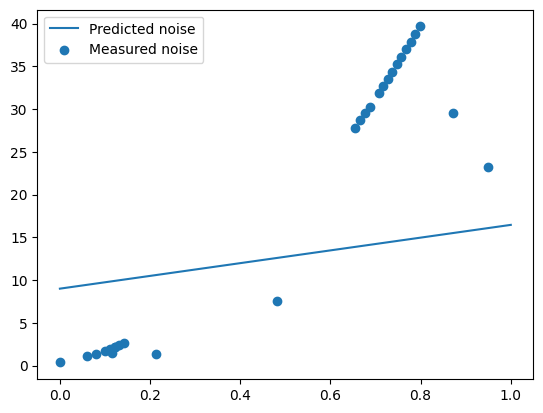

[14 12 13 11  6  8 10  7]


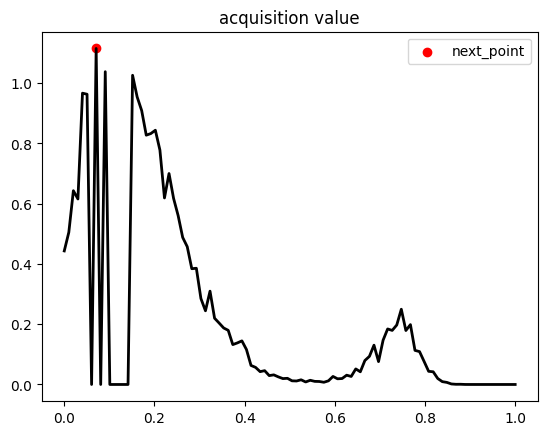

Step:9


sample: 100%|██████████| 1000/1000 [00:18<00:00, 52.94it/s, 3 steps of size 8.04e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.47      0.29      0.40      0.16      0.84    163.03      1.02
    k_scale     18.47     14.16     15.18      2.78     35.07    283.53      1.01
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



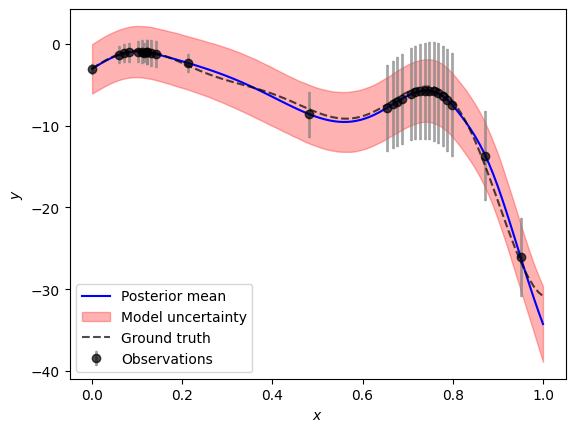

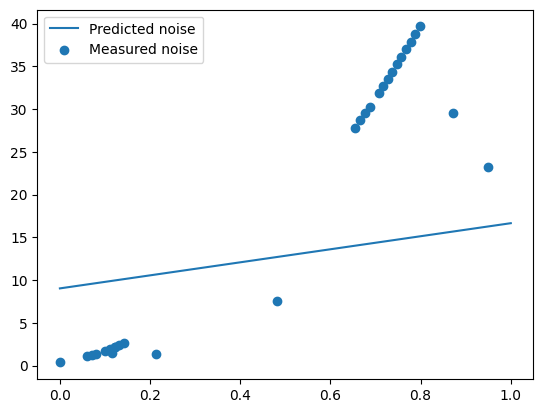

[14 12 13 11  6  8 10  7  9]


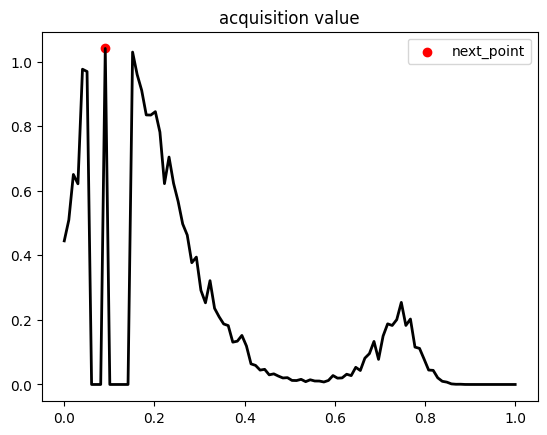

Step:10


sample: 100%|██████████| 1000/1000 [00:19<00:00, 51.04it/s, 3 steps of size 7.36e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.43      0.22      0.38      0.17      0.76    268.99      1.00
    k_scale     20.05     17.99     15.21      1.25     38.86    272.84      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



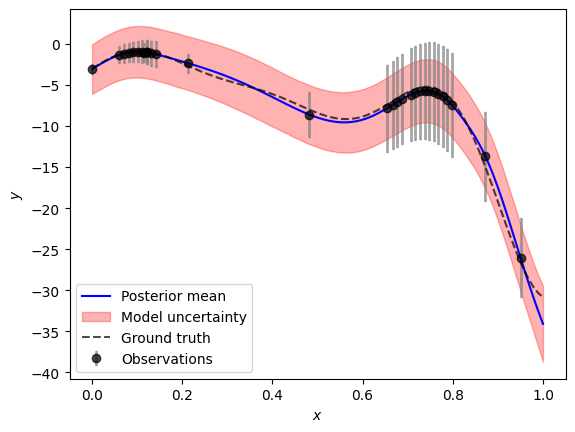

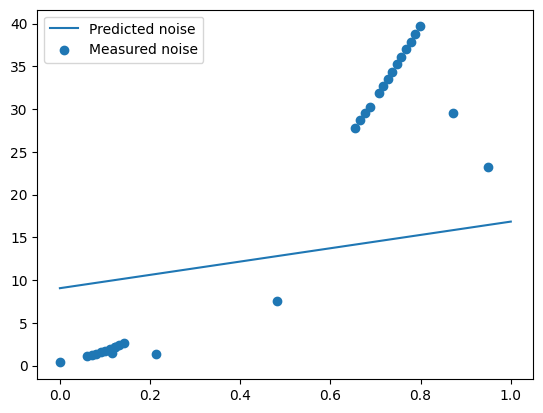

[14 12 13 11  6  8 10  7  9 15]


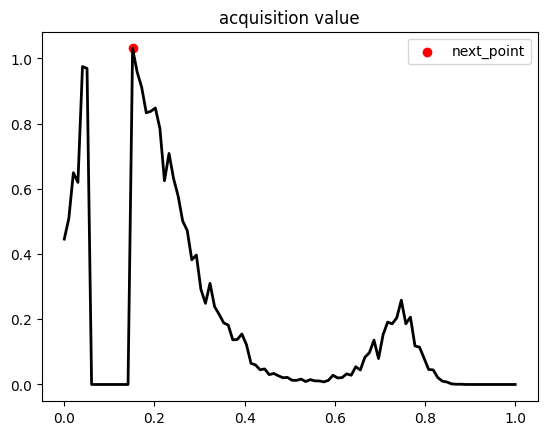

Step:11


sample: 100%|██████████| 1000/1000 [00:21<00:00, 45.77it/s, 3 steps of size 8.35e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.46      0.26      0.38      0.12      0.75    232.19      1.00
    k_scale     20.03     19.42     15.36      1.75     38.12    325.84      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



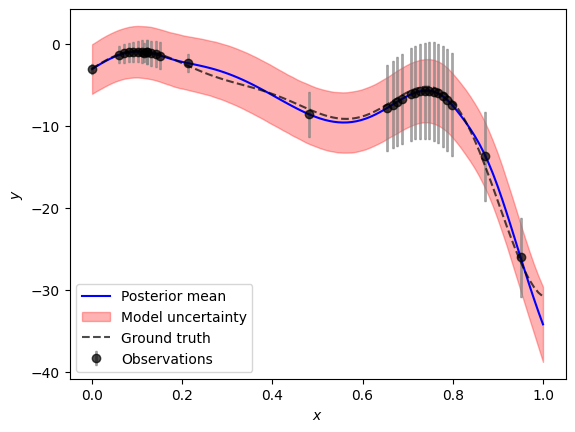

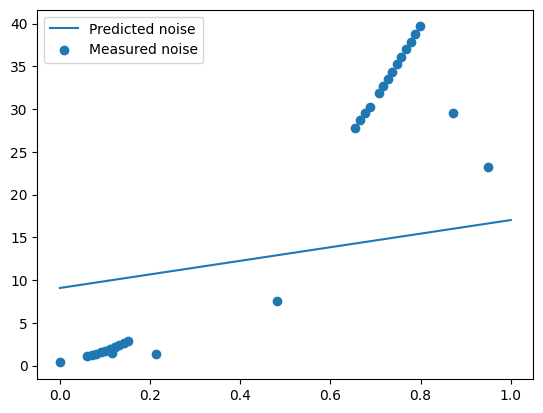

[14 12 13 11  6  8 10  7  9 15  4]


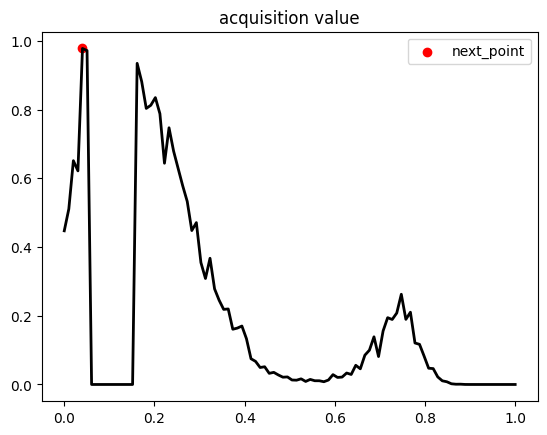

Step:12


sample: 100%|██████████| 1000/1000 [00:06<00:00, 152.03it/s, 3 steps of size 7.95e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.45      0.25      0.39      0.13      0.73    231.08      1.00
    k_scale     19.93     17.13     15.67      2.36     40.43    310.24      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



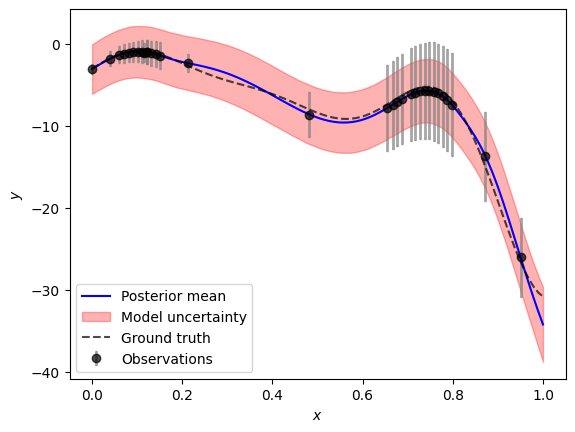

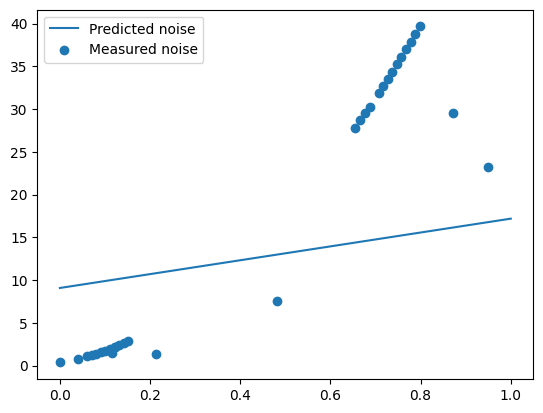

[14 12 13 11  6  8 10  7  9 15  4  5]


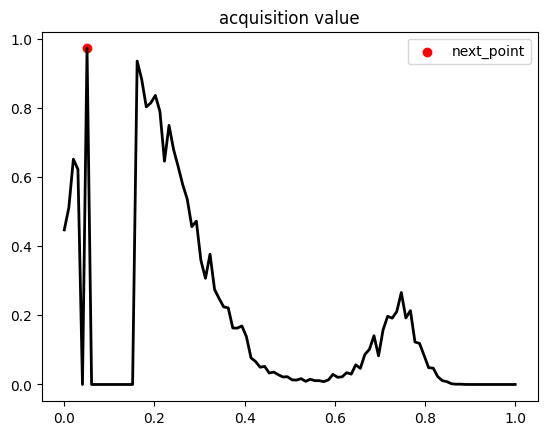

Step:13


sample: 100%|██████████| 1000/1000 [00:07<00:00, 138.81it/s, 3 steps of size 8.62e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.44      0.21      0.39      0.16      0.74    345.23      1.00
    k_scale     18.32     13.17     15.24      2.72     33.87    262.68      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



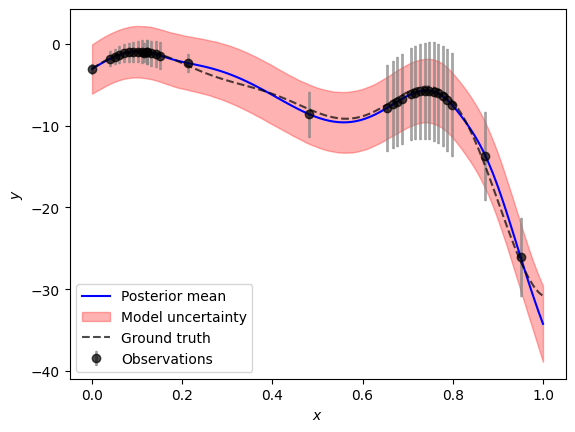

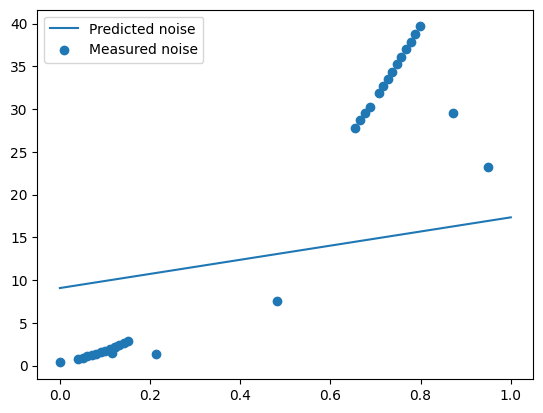

[14 12 13 11  6  8 10  7  9 15  4  5 16]


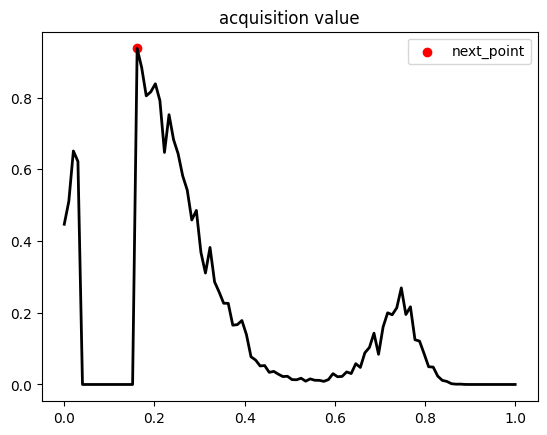

Step:14


sample: 100%|██████████| 1000/1000 [00:07<00:00, 141.36it/s, 3 steps of size 8.17e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.45      0.27      0.38      0.12      0.71    193.49      1.01
    k_scale     17.77     12.44     14.77      1.93     33.62    265.48      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



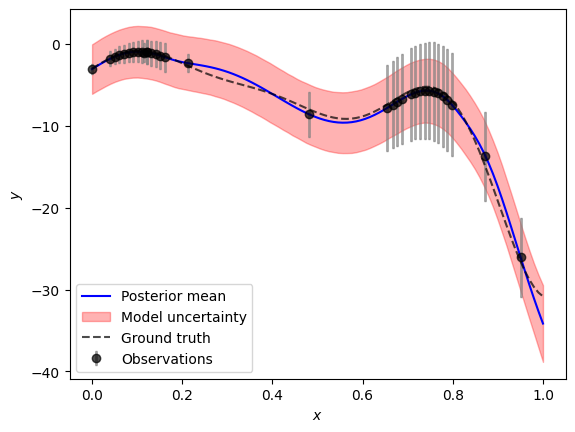

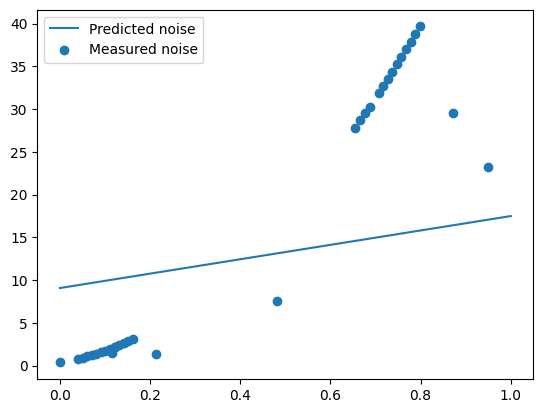

[14 12 13 11  6  8 10  7  9 15  4  5 16 17]


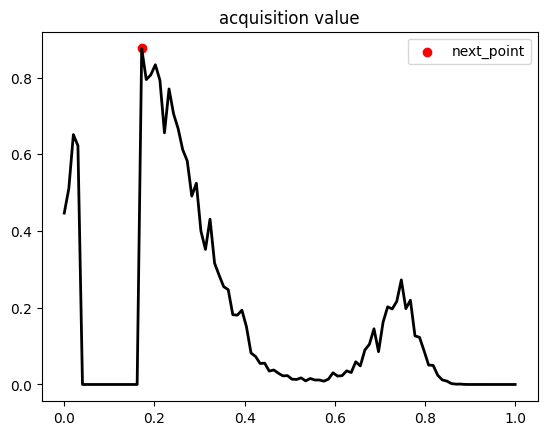

Step:15


sample: 100%|██████████| 1000/1000 [00:06<00:00, 144.21it/s, 3 steps of size 8.86e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.46      0.25      0.41      0.15      0.76    218.73      1.00
    k_scale     19.04     16.98     14.87      2.22     35.17    321.90      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



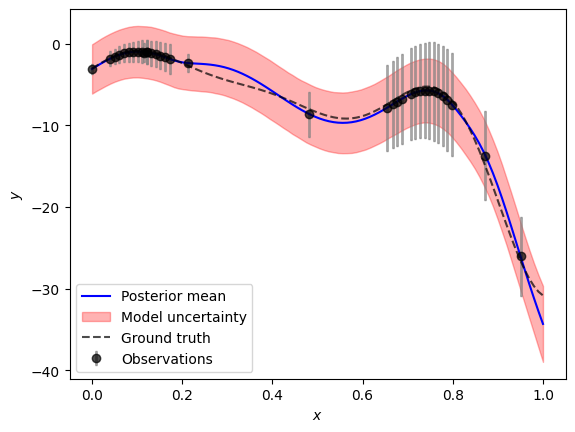

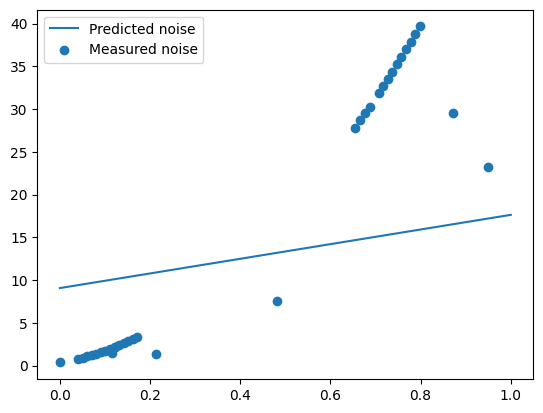

[14 12 13 11  6  8 10  7  9 15  4  5 16 17 20]


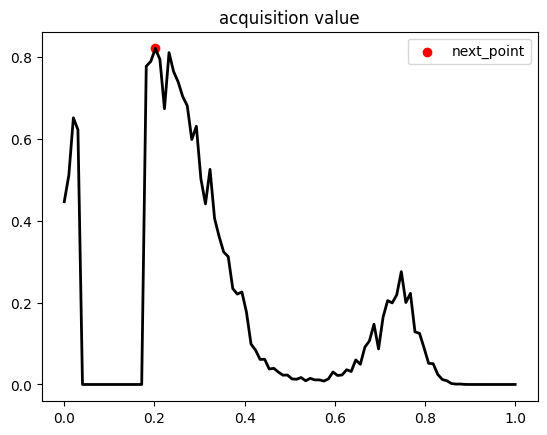

In [24]:
N = 15
X_test =xs
#X_test = np.reshape(X_test,(X_test.shape[0],1))
X_test_full = xs
#X_test_full = np.reshape(X_test_full,(X_test_full.shape[0],1))
# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()
idx = []
for i in range(1, N+1):
    print("Step:"+str(i))

    # Calculate mean values of the measured samples
    train_ym = np.mean(train_y, axis=1)
    # Calculate noise of the measured samples
    train_noise = np.var(train_y, axis=1)

    #train_noise = train_noise*10 #Scalling to validate (Dont need for real implementation)
    # Initialize MF model
    gp_model = gpax.MeasuredNoiseGP(1, kernel='Matern')
    # Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
    gp_model.fit(rng_key, train_x, train_ym, train_noise, num_warmup=500, num_samples=500, num_chains=1)


    if ((i == 1) or ((i % 1) == 0)): # Check predictions after every 5 BO runs
        y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test, noise_prediction_method='linreg', n=100)


        # Plot results
        _, ax = plt.subplots(dpi=100)
        ax.set_xlabel("$x$")
        ax.set_ylabel("$y$")
        ax.errorbar(
            train_x, train_ym, yerr=np.sqrt(train_noise), fmt='o', color='black', ecolor='grey',
            alpha=0.7, elinewidth=2, capsize=1, label='Observations', zorder=2)
        ax.plot(X_test, y_pred, lw=1.5, zorder=2, c='b', label='Posterior mean')
        ax.fill_between(X_test, y_pred - y_sampled.std(axis=(0,1)), y_pred + y_sampled.std(axis=(0,1)),
                        color='r', alpha=0.3, label="Model uncertainty")
        ax.plot(X_test, forrester_function(X_test), '--', label='Ground truth', c='k', alpha=0.7, zorder=2)
        ax.legend(loc='best')
        plt.show()
        # Plot predicted (and measured) noise
        plt.plot(X_test, gp_model.noise_predicted, label="Predicted noise")
        plt.scatter(train_x, train_noise, label="Measured noise")
        plt.legend()
        plt.show()

    # Compute the MF acq function - EI based

    acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, maximize=True, noiseless=True)

    # Avoiding measurement at same locations
    acq=np.array(acq)
    acq[idx] = 0
    next_point_idx = acq.argmax()
    next_point_val = acq.max()
    idx = np.hstack((idx, next_point_idx))
    if i == 1:
        idx = int(idx)
        print(idx)
    else:
        idx = idx
        print(idx)

    #Plotting acq function
    plt.plot(X_test, acq, "k-", linewidth=2)
    plt.scatter(X_test[next_point_idx], next_point_val, c="r", label="next_point")
    plt.legend(loc="best")
    plt.title("acquisition value")
    plt.show()

    if next_point_val == 0:
        print("Model sufficiently learned")
        break
    else:
        next_point = X_test[next_point_idx]
        train_x = np.hstack((train_x, next_point))
        #print(next_point_idx, next_point, next_point_norm, train_x_full, train_x_full_norm)
        np.random.seed(1)
        t_y= np.array(forrester_function(train_x[-1]) + np.random.normal(0, variable_noise(train_x[-1]), num_measurements))
        train_y = np.vstack((train_y, t_y))

